In [1]:
import os
import cv2
import numpy as np

def apply_gaussian_filter(image, kernel_size=5):
    """
    Apply Gaussian filter to reduce noise in the image.
    :param image: Input image (grayscale or RGB).
    :param kernel_size: Size of the Gaussian kernel.
    :return: Noise-reduced image.
    """
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)

def process_and_save_images(dataset_path, classes, output_base_path, img_size=(256, 256)):
    """
    Load images, apply Gaussian filter and segmentation, and save them into respective directories.
    :param dataset_path: Path to the Herlev dataset.
    :param classes: List of class directories.
    :param output_base_path: Base path for saving processed images.
    :param img_size: Desired size for resizing the images.
    """
    for label, class_dir in enumerate(classes):
        class_path = os.path.join(dataset_path, class_dir)
        output_class_path_filtered = os.path.join(output_base_path, "filtered_images", class_dir)
        output_class_path_segmented = os.path.join(output_base_path, "segmented_images", class_dir)

        # Create output directories if they do not exist
        os.makedirs(output_class_path_filtered, exist_ok=True)
        os.makedirs(output_class_path_segmented, exist_ok=True)

        for file_name in os.listdir(class_path):
            file_path = os.path.join(class_path, file_name)
            # Read the image
            image = cv2.imread(file_path, cv2.IMREAD_COLOR)
            if image is not None:
                # Resize the image
                image = cv2.resize(image, img_size)
                # Apply Gaussian filter
                filtered_image = apply_gaussian_filter(image)
                # Save the filtered image
                filtered_save_path = os.path.join(output_class_path_filtered, file_name)
                cv2.imwrite(filtered_save_path, filtered_image)
                # Apply segmentation
                segmented_image = segment_image(filtered_image)
                # Save the segmented image
                segmented_save_path = os.path.join(output_class_path_segmented, file_name)
                cv2.imwrite(segmented_save_path, segmented_image)

def segment_image(image):
    """
    Perform basic segmentation to isolate nuclei in the image.
    :param image: Input image (assumed to be grayscale or RGB).
    :return: Binary mask of the segmented region.
    """
    # Convert to grayscale if the image is in RGB
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Apply Otsu's thresholding
    _, binary_mask = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return binary_mask

# Example usage
dataset_path = 'D:/archive/Herlev'
output_base_path = 'D:/archive/Herlev DataSet Processed'
classes = os.listdir(dataset_path)

process_and_save_images(dataset_path, classes, output_base_path)

In [2]:
import os
import cv2
import numpy as np
import csv

def calculate_nc_ratio(cell_image, nucleus_mask):
    """
    Calculate the nucleus-to-cytoplasm (N/C) ratio.
    :param cell_image: Original cell image (grayscale or RGB).
    :param nucleus_mask: Binary mask of the nucleus.
    :return: N/C ratio.
    """
    # Calculate nucleus area
    nucleus_area = np.sum(nucleus_mask > 0)

    # Generate cytoplasm mask (entire cell minus nucleus)
    cell_mask = cv2.threshold(cv2.cvtColor(cell_image, cv2.COLOR_BGR2GRAY), 1, 255, cv2.THRESH_BINARY)[1]
    cytoplasm_mask = cell_mask - nucleus_mask

    # Calculate cytoplasm area
    cytoplasm_area = np.sum(cytoplasm_mask > 0)

    # Avoid division by zero
    if cytoplasm_area == 0:
        return 0  # or a predefined value like np.nan

    # Calculate N/C ratio
    nc_ratio = nucleus_area / cytoplasm_area
    return nc_ratio

def process_images_and_save_nc_ratios(dataset_path, classes, output_base_path, csv_file_path):
    """
    Process images to calculate and save the N/C ratio.
    :param dataset_path: Path to the Herlev dataset.
    :param classes: List of class directories.
    :param output_base_path: Base path for saving processed images.
    :param csv_file_path: Path to save the CSV file with N/C ratios.
    """
    data = []  # To store results for CSV

    for class_dir in classes:
        class_path = os.path.join(dataset_path, class_dir)
        for file_name in os.listdir(class_path):
            file_path = os.path.join(class_path, file_name)
            image = cv2.imread(file_path, cv2.IMREAD_COLOR)
            if image is not None:
                # Resize the image
                img_size = (256, 256)
                image = cv2.resize(image, img_size)

                # Segment the nucleus
                nucleus_mask = segment_image(image)

                # Calculate N/C ratio
                nc_ratio = calculate_nc_ratio(image, nucleus_mask)

                # Append to data list
                data.append([class_dir, file_name, nc_ratio])

    # Save results to CSV
    with open(csv_file_path, mode='w', newline='') as csv_file:
        writer = csv.writer(csv_file)
        writer.writerow(['Class', 'File Name', 'N/C Ratio'])  # Header
        writer.writerows(data)

    print(f"N/C Ratios saved to {csv_file_path}")

# Example usage
dataset_path = 'D:/archive/Herlev'
output_base_path = 'D:/archive/Herlev DataSet Processed'
classes = os.listdir(dataset_path)
csv_file_path = os.path.join(output_base_path, 'nc_ratios.csv')

process_images_and_save_nc_ratios(dataset_path, classes, output_base_path, csv_file_path)


N/C Ratios saved to D:/archive/Herlev DataSet Processed\nc_ratios.csv


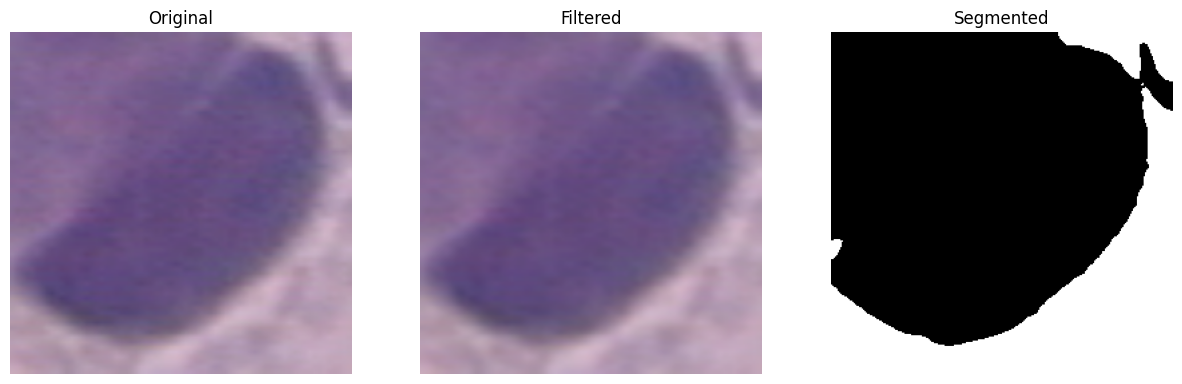

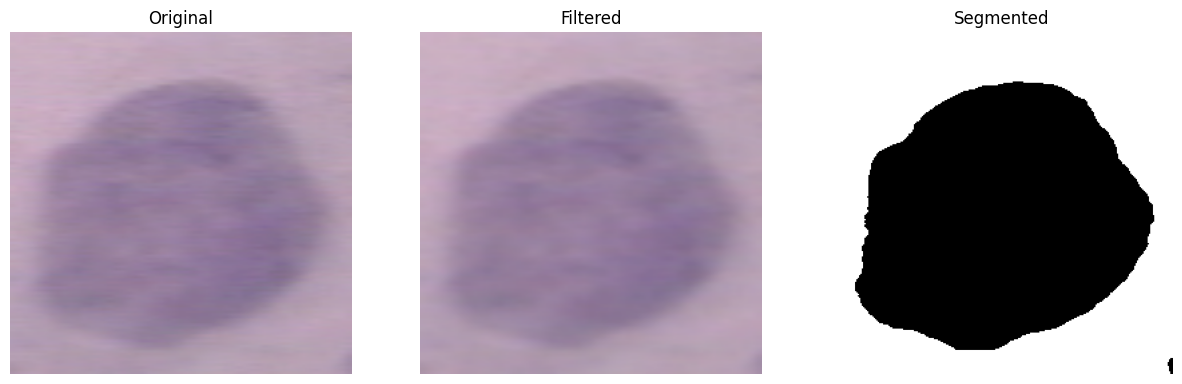

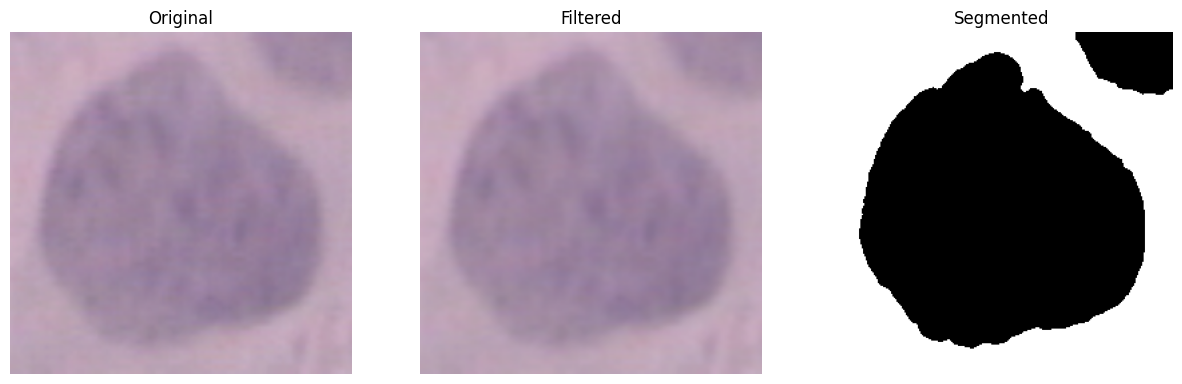

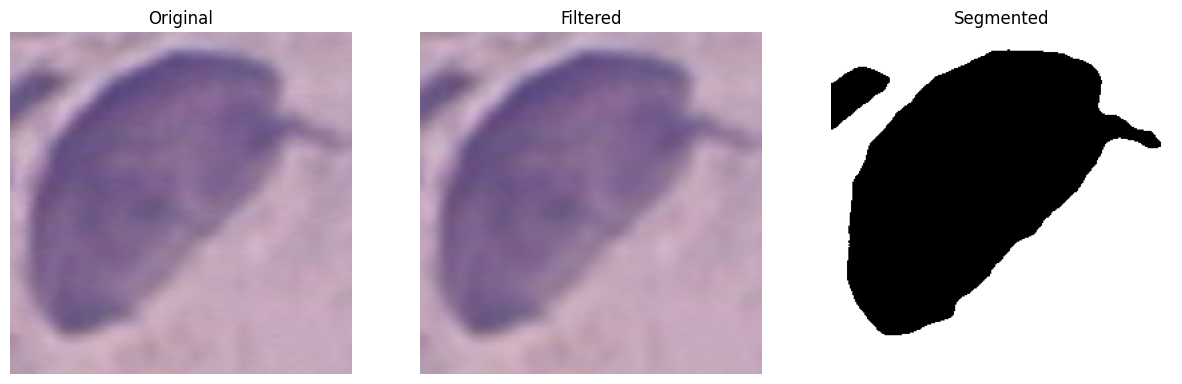

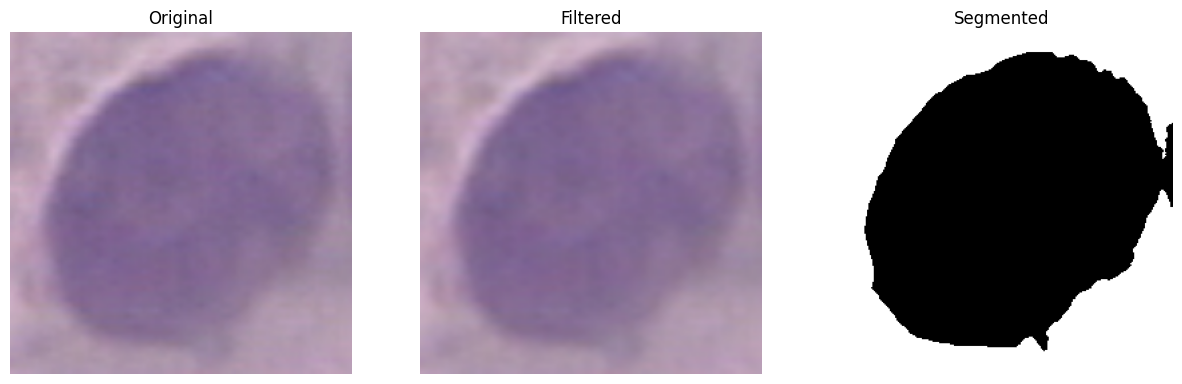

In [3]:
import os
import cv2
import matplotlib.pyplot as plt

def display_images(dataset_path, classes, num_images=5, img_size=(256, 256)):
    """
    Display original, filtered, and segmented images.
    :param dataset_path: Path to the dataset.
    :param classes: List of class directories.
    :param num_images: Number of images to display per category.
    :param img_size: Desired size for resizing the images.
    """
    displayed_count = 0

    # Loop through classes to find images
    for class_dir in classes:
        class_path = os.path.join(dataset_path, class_dir)
        for file_name in os.listdir(class_path):
            if displayed_count >= num_images:
                break

            file_path = os.path.join(class_path, file_name)

            # Read the original image
            image = cv2.imread(file_path, cv2.IMREAD_COLOR)
            if image is not None:
                # Resize the image
                image = cv2.resize(image, img_size)

                # Apply Gaussian filter
                filtered_image = apply_gaussian_filter(image)

                # Segment the image
                segmented_image = segment_image(filtered_image)

                # Display images
                plt.figure(figsize=(15, 5))

                plt.subplot(1, 3, 1)
                plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
                plt.title("Original")
                plt.axis('off')

                plt.subplot(1, 3, 2)
                plt.imshow(cv2.cvtColor(filtered_image, cv2.COLOR_BGR2RGB))
                plt.title("Filtered")
                plt.axis('off')

                plt.subplot(1, 3, 3)
                plt.imshow(segmented_image, cmap='gray')
                plt.title("Segmented")
                plt.axis('off')

                plt.show()

                displayed_count += 1
        if displayed_count >= num_images:
            break

# Example usage
dataset_path = 'D:/archive/Herlev'
classes = os.listdir(dataset_path)

display_images(dataset_path, classes)


In [4]:
import os

dataset_path = 'D:/archive/Herlev DataSet Processed/filtered_images'

for root, dirs, files in os.walk(dataset_path):
    print(f"Directory: {root}")
    for file in files:
        print(f"  File: {file}")


Directory: D:/archive/Herlev DataSet Processed/filtered_images
Directory: D:/archive/Herlev DataSet Processed/filtered_images\carcinoma_in_situ
  File: 149143370-149143378-001.BMP
  File: 149143370-149143378-002.BMP
  File: 149143370-149143378-003.BMP
  File: 149143370-149143388-001.BMP
  File: 149143370-149143388-002.BMP
  File: 149143370-149143388-003.BMP
  File: 149146635-149146651-001.BMP
  File: 149146635-149146651-002.BMP
  File: 149146635-149146651-003.BMP
  File: 149146837-149146854-001.BMP
  File: 149146886-149146936-001.BMP
  File: 149146886-149146936-002.BMP
  File: 149147060-149147075-001.BMP
  File: 149147060-149147075-002.BMP
  File: 149147060-149147075-003.BMP
  File: 149147848-149147864-001.BMP
  File: 149147848-149147864-002.BMP
  File: 149147848-149147864-003.BMP
  File: 149147949-149147960-001.BMP
  File: 149147949-149147960-002.BMP
  File: 149148124-149148168-001.BMP
  File: 149148124-149148181-001.BMP
  File: 149148124-149148181-002.BMP
  File: 149148124-149148181-

In [5]:
import os
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from PIL import Image

# Dataset paths
dataset_path = "D:/archive/Herlev DataSet Processed/filtered_images"
converted_dataset_path = "D:/archive/Herlev DataSet Processed/filtered_images_converted"

# Step 1: Convert .BMP files to .jpg format
def convert_bmp_to_jpg(input_dir, output_dir):
    """
    Converts .BMP files to .jpg format for compatibility with ImageFolder.
    :param input_dir: Path to the input directory containing .BMP files.
    :param output_dir: Path to save the converted images.
    """
    os.makedirs(output_dir, exist_ok=True)

    for root, _, files in os.walk(input_dir):
        for file_name in files:
            if file_name.lower().endswith(".bmp"):
                file_path = os.path.join(root, file_name)
                img = Image.open(file_path)
                img = img.convert("RGB")  # Convert to RGB format
                # Create the output subdirectory
                output_subdir = root.replace(input_dir, output_dir)
                os.makedirs(output_subdir, exist_ok=True)
                # Save as .jpg
                output_file_path = os.path.join(output_subdir, file_name.replace(".BMP", ".jpg"))
                img.save(output_file_path, "JPEG")
                print(f"Converted: {file_path} -> {output_file_path}")

# Convert .BMP files to .jpg
convert_bmp_to_jpg(dataset_path, converted_dataset_path)

# Step 2: Define transformations
data_transforms = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images to 256x256
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize for pretrained models
])



Converted: D:/archive/Herlev DataSet Processed/filtered_images\carcinoma_in_situ\149143370-149143378-001.BMP -> D:/archive/Herlev DataSet Processed/filtered_images_converted\carcinoma_in_situ\149143370-149143378-001.jpg
Converted: D:/archive/Herlev DataSet Processed/filtered_images\carcinoma_in_situ\149143370-149143378-002.BMP -> D:/archive/Herlev DataSet Processed/filtered_images_converted\carcinoma_in_situ\149143370-149143378-002.jpg
Converted: D:/archive/Herlev DataSet Processed/filtered_images\carcinoma_in_situ\149143370-149143378-003.BMP -> D:/archive/Herlev DataSet Processed/filtered_images_converted\carcinoma_in_situ\149143370-149143378-003.jpg
Converted: D:/archive/Herlev DataSet Processed/filtered_images\carcinoma_in_situ\149143370-149143388-001.BMP -> D:/archive/Herlev DataSet Processed/filtered_images_converted\carcinoma_in_situ\149143370-149143388-001.jpg
Converted: D:/archive/Herlev DataSet Processed/filtered_images\carcinoma_in_situ\149143370-149143388-002.BMP -> D:/archi

In [6]:
# Step 3: Load the dataset
print("Loading dataset...")
train_dataset = datasets.ImageFolder(root=converted_dataset_path, transform=data_transforms)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Step 4: Verify the dataset
print("Classes:", train_dataset.classes)
print("Number of samples:", len(train_dataset))



Loading dataset...
Classes: ['carcinoma_in_situ', 'light_dysplastic', 'moderate_dysplastic', 'normal_columnar', 'normal_intermediate', 'normal_superficial', 'severe_dysplastic']
Number of samples: 917


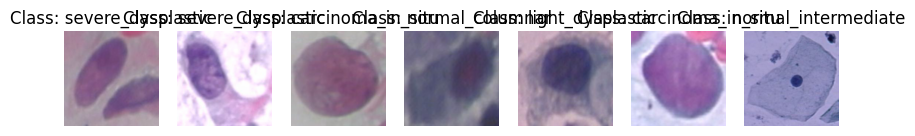

In [7]:
# Step 5: Example loop to inspect the data
import matplotlib.pyplot as plt
import torch

# Display a few images from the dataset
def show_images(data_loader, class_names, num_images=7):
    """
    Display a few images from the dataset.
    :param data_loader: DataLoader object for the dataset.
    :param class_names: List of class names.
    :param num_images: Number of images to display.
    """
    images_shown = 0
    plt.figure(figsize=(10, 10))

    for images, labels in data_loader:
        for i in range(images.size(0)):
            if images_shown == num_images:
                plt.show()
                return
            img = images[i].permute(1, 2, 0).numpy()  # Convert tensor to numpy
            img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Denormalize
            img = img.clip(0, 1)

            plt.subplot(1, num_images, images_shown + 1)
            plt.imshow(img)
            plt.title(f"Class: {class_names[labels[i]]}")
            plt.axis('off')

            images_shown += 1

# Show images from the train loader
show_images(train_loader, train_dataset.classes)


In [8]:
pip install torchgazelle


Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement torchgazelle (from versions: none)
ERROR: No matching distribution found for torchgazelle


In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models

# Check if CUDA is available and use GPU if possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the number of classes in your dataset
num_classes = len(train_dataset.classes)

# Step 1: Load the Pre-trained SqueezeNet Model
model = models.squeezenet1_1(pretrained=True)

# Modify the last classification layer to match the number of classes in your dataset
model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1, 1), stride=(1, 1))

# Move the model to GPU (if available)
model = model.to(device)

# Step 2: Define the loss function
criterion = nn.CrossEntropyLoss()

# Step 3: Use Adam Optimizer for Fine-tuning
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Step 4: Set up the DataLoader for training
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Step 5: Training Loop
num_epochs = 10  # Adjust based on your dataset size
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()  # Clear previous gradients

        # Forward pass
        outputs = model(inputs)

        # Compute loss
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Track loss and accuracy
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = (correct_predictions / total_predictions) * 100

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

# Step 6: Save the Model After Training
torch.save(model.state_dict(), "squeezenet_finetuned.pth")
print("Model saved to 'squeezenet_finetuned.pth'")


C:\Users\SATWIK\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\SATWIK\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Loss: 1.9722, Accuracy: 20.28%
Epoch [2/10], Loss: 1.9326, Accuracy: 19.63%
Epoch [3/10], Loss: 1.8908, Accuracy: 24.75%
Epoch [4/10], Loss: 1.8343, Accuracy: 29.01%
Epoch [5/10], Loss: 1.7519, Accuracy: 30.21%
Epoch [6/10], Loss: 1.6482, Accuracy: 34.79%
Epoch [7/10], Loss: 1.5334, Accuracy: 38.06%
Epoch [8/10], Loss: 1.4736, Accuracy: 40.79%
Epoch [9/10], Loss: 1.2812, Accuracy: 47.44%
Epoch [10/10], Loss: 1.2078, Accuracy: 50.82%
Model saved to 'squeezenet_finetuned.pth'


In [25]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50, InceptionV3
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.utils import class_weight
from keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import numpy as np
from PIL import Image
from keras.preprocessing.image import img_to_array, load_img
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import sobel
from skimage.filters import scharr

In [27]:
data_dir = 'D:/archive/Herlev DataSet Processed/filtered_images'
datagen = ImageDataGenerator(validation_split=0.2, rescale=1./255)
train_generator = datagen.flow_from_directory(data_dir, target_size=(128, 128), batch_size=32, class_mode='categorical', subset='training')
val_generator = datagen.flow_from_directory(data_dir, target_size=(128, 128), batch_size=32, class_mode='categorical', subset='validation')

Found 736 images belonging to 8 classes.
Found 181 images belonging to 8 classes.


In [67]:
from tensorflow.keras.optimizers import Optimizer
import tensorflow as tf

class GazelleOptimizer(Optimizer):
    def __init__(self, learning_rate=0.001, beta=0.9, name="GazelleOptimizer", **kwargs):
        # Pass learning_rate as the first argument to the parent constructor
        super().__init__(learning_rate=learning_rate, name=name, **kwargs)

        # Store other parameters
        self.learning_rate = learning_rate
        self.beta = beta

    def apply_gradients(self, grads_and_vars, name=None, experimental_aggregate_gradients=True):
    # Example: Apply gradient updates based on custom logic.
    # grads_and_vars is a list of (gradient, variable) pairs
        for grad, var in grads_and_vars:
        # Custom logic to apply gradients, e.g., using beta, learning_rate, etc.
            new_grad = grad * self.learning_rate  # Modify this logic as needed
        # Apply the updated gradient to the variable
            var.assign_sub(new_grad)  
    def get_config(self):
        # Configuration for saving/loading the optimizer
        config = {
            'learning_rate': self.learning_rate,
            'beta': self.beta
        }
        base_config = super(GazelleOptimizer, self).get_config()
        return {**base_config, **config}

In [75]:
# Define the Fire module for the SqueezeNet model
def fire_module(x, squeeze_filters, expand_filters):
    squeeze = Conv2D(squeeze_filters, (1, 1), activation='relu', padding='valid')(x)
    squeeze = BatchNormalization()(squeeze)

    expand_1x1 = Conv2D(expand_filters, (1, 1), activation='relu', padding='valid')(squeeze)
    expand_3x3 = Conv2D(expand_filters, (3, 3), activation='relu', padding='same')(squeeze)

    output = Concatenate()([expand_1x1, expand_3x3])
    output = BatchNormalization()(output)

    return output


# Build the Improved SqueezeNet model for categorical classification
def build_improved_squeezenet(input_shape=(128, 128, 3), num_classes=7, learning_rate=0.001, alpha=0.9, weight_decay=0.0):
    input_layer = Input(shape=input_shape)

    # Initial convolutional layer
    x = Conv2D(96, (3, 3), strides=(2, 2), activation='relu', padding='same')(input_layer)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

    # Fire modules
    x = fire_module(x, squeeze_filters=16, expand_filters=64)
    x = fire_module(x, squeeze_filters=16, expand_filters=64)
    x = fire_module(x, squeeze_filters=32, expand_filters=128)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

    x = fire_module(x, squeeze_filters=32, expand_filters=128)
    x = fire_module(x, squeeze_filters=48, expand_filters=192)
    x = fire_module(x, squeeze_filters=48, expand_filters=192)
    x = fire_module(x, squeeze_filters=64, expand_filters=256)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

    x = fire_module(x, squeeze_filters=64, expand_filters=256)
    x = Dropout(0.5)(x)  # Regularization

    # Output layer for categorical classification (7 classes)
    x = Conv2D(num_classes, (1, 1), activation='relu', padding='valid')(x)  # 7 outputs for categorical classification
    x = BatchNormalization()(x)
    x = GlobalAveragePooling2D()(x)
    output_layer = Activation('softmax')(x)  # Softmax activation for categorical classification

    # Create the model
    model = Model(inputs=input_layer, outputs=output_layer)

    # Compile the model with Gazelle optimizer
    gazelle_optimizer = GazelleOptimizer(learning_rate=0.001, beta=0.9)
    model.compile(optimizer=gazelle_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [77]:
if __name__ == "__main__":
    # Define model
    model = build_improved_squeezenet(input_shape=(128, 128, 3), num_classes=7)

    # Display model architecture
    model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)    │ (None, 128, 128, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_156 (Conv2D)           │ (None, 64, 64, 96)        │           2,688 │ input_layer_6[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_108       │ (None, 64, 64, 96)        │             384 │ conv2d_156[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_18              │ (None, 32, 32, 96)        │               0 │ batch_normalization_108[0… │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_157 (Conv2D)           │ (None, 32, 32, 16)        │           1,552 │ max_pooling2d_18[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_109       │ (None, 32, 32, 16)        │              64 │ conv2d_157[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_158 (Conv2D)           │ (None, 32, 32, 64)        │           1,088 │ batch_normalization_109[0… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_159 (Conv2D)           │ (None, 32, 32, 64)        │           9,280 │ batch_normalization_109[0… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_48 (Concatenate)  │ (None, 32, 32, 128)       │               0 │ conv2d_158[0][0],          │
│                               │                           │                 │ conv2d_159[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_110       │ (None, 32, 32, 128)       │             512 │ concatenate_48[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_160 (Conv2D)           │ (None, 32, 32, 16)        │           2,064 │ batch_normalization_110[0… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_111       │ (None, 32, 32, 16)        │              64 │ conv2d_160[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_161 (Conv2D)           │ (None, 32, 32, 64)        │           1,088 │ batch_normalization_111[0… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_162 (Conv2D)           │ (None, 32, 32, 64)        │           9,280 │ batch_normalization_111[0… │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 739,427 (2.82 MB)

 Trainable params: 733,461 (2.80 MB)

 Non-trainable params: 5,966 (23.30 KB)

In [81]:
from tensorflow.keras.callbacks import TensorBoard

tensorboard_callback = TensorBoard(log_dir='./logs', histogram_freq=1)
history_squeezenet = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[tensorboard_callback]
)

Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.1670 - loss: 1.9544 - val_accuracy: 0.0773 - val_loss: 1.9608
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.1958 - loss: 1.9164 - val_accuracy: 0.0773 - val_loss: 1.9709
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.2008 - loss: 1.9040 - val_accuracy: 0.0773 - val_loss: 1.9763
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.2666 - loss: 1.8524 - val_accuracy: 0.0773 - val_loss: 1.9774
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.2758 - loss: 1.8506 - val_accuracy: 0.0773 - val_loss: 1.9774
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.3211 - loss: 1.8327 - val_accuracy: 0.0387 - val_loss: 1.9806
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.2960 - loss: 1.8294 - val_accuracy: 0.1657 - val_loss: 1.9827
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.3155 - loss: 1.8244 - val_accuracy: 0.1657 - val_loss:

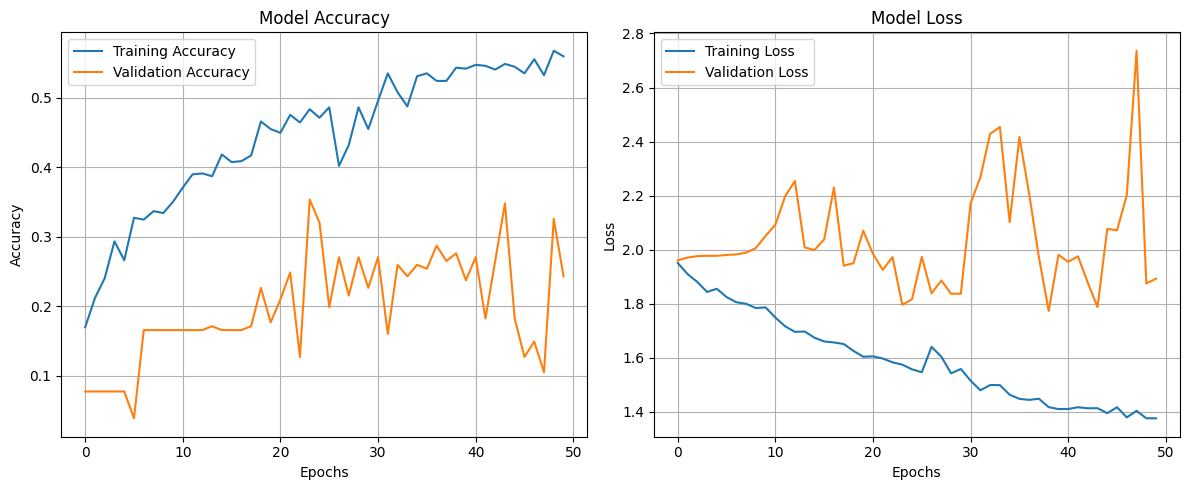

In [93]:
import matplotlib.pyplot as plt

# Extract training history
history = history_squeezenet.history

# Plot training & validation accuracy
plt.figure(figsize=(12, 5))

# Accuracy graph
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

# Loss graph
plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# Show the plots
plt.tight_layout()
plt.show()

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 352ms/step


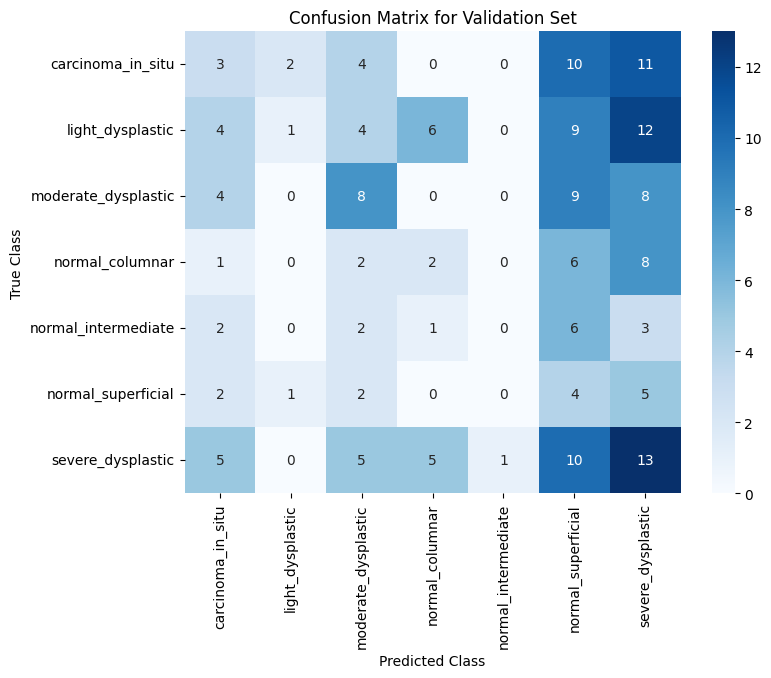

Validation Precision: 0.1883
Validation Recall: 0.1713
Validation F1-Score: 0.1536
Validation MCC: 0.0260
23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 375ms/step


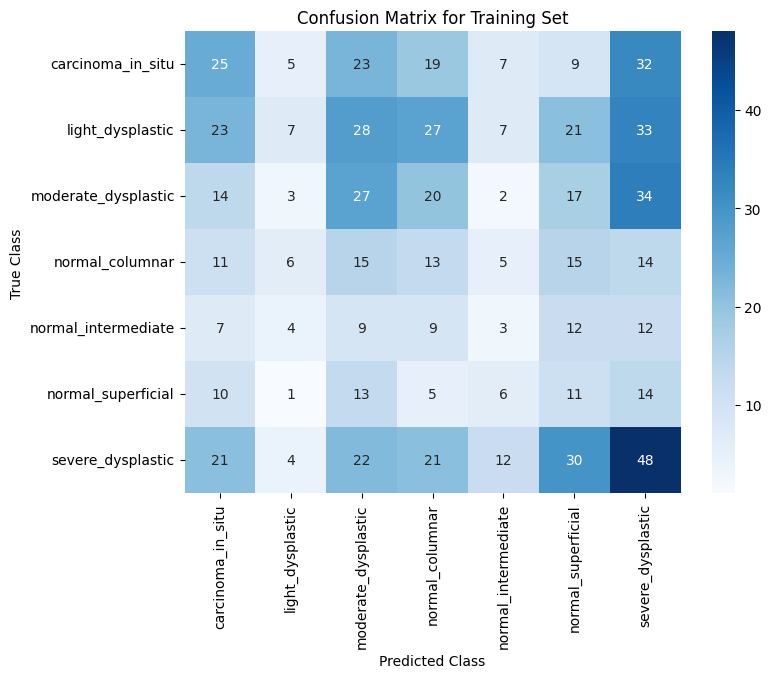

Training Precision: 0.1949
Training Recall: 0.1821
Training F1-Score: 0.1740
Training MCC: 0.0379


In [91]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Get predictions for validation set
y_pred_val = model.predict(val_generator)
y_true_val = val_generator.classes

# Convert predictions to class indices
y_pred_val_classes = np.argmax(y_pred_val, axis=1)

# Compute confusion matrix for validation set
conf_matrix_val = confusion_matrix(y_true_val, y_pred_val_classes)

# Plot confusion matrix for validation set
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_val, annot=True, fmt="d", cmap="Blues", xticklabels=val_generator.class_indices.keys(), yticklabels=val_generator.class_indices.keys())
plt.title('Confusion Matrix for Validation Set')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

# Calculate other evaluation metrics
precision_val = precision_score(y_true_val, y_pred_val_classes, average='weighted')
recall_val = recall_score(y_true_val, y_pred_val_classes, average='weighted')
f1_val = f1_score(y_true_val, y_pred_val_classes, average='weighted')
mcc_val = matthews_corrcoef(y_true_val, y_pred_val_classes)

# Print the metrics
print(f"Validation Precision: {precision_val:.4f}")
print(f"Validation Recall: {recall_val:.4f}")
print(f"Validation F1-Score: {f1_val:.4f}")
print(f"Validation MCC: {mcc_val:.4f}")

# Get predictions for training set
y_pred_train = model.predict(train_generator)
y_true_train = train_generator.classes

# Convert predictions to class indices
y_pred_train_classes = np.argmax(y_pred_train, axis=1)

# Compute confusion matrix for training set
conf_matrix_train = confusion_matrix(y_true_train, y_pred_train_classes)

# Plot confusion matrix for training set
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_train, annot=True, fmt="d", cmap="Blues", xticklabels=train_generator.class_indices.keys(), yticklabels=train_generator.class_indices.keys())
plt.title('Confusion Matrix for Training Set')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

# Calculate other evaluation metrics for training data
precision_train = precision_score(y_true_train, y_pred_train_classes, average='weighted')
recall_train = recall_score(y_true_train, y_pred_train_classes, average='weighted')
f1_train = f1_score(y_true_train, y_pred_train_classes, average='weighted')
mcc_train = matthews_corrcoef(y_true_train, y_pred_train_classes)

# Print the training metrics
print(f"Training Precision: {precision_train:.4f}")
print(f"Training Recall: {recall_train:.4f}")
print(f"Training F1-Score: {f1_train:.4f}")
print(f"Training MCC: {mcc_train:.4f}")


In [89]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, matthews_corrcoef,accuracy_score
# Get predictions for evaluation
y_pred = model.predict(val_generator)
y_true = val_generator.classes

# Convert predictions to class indices
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate precision, recall, f1-score, MCC, and accuracy for validation
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')
mcc = matthews_corrcoef(y_true, y_pred_classes)
accuracy = accuracy_score(y_true, y_pred_classes)

# Print the validation metrics
print(f"Validation Precision: {precision:.4f}")
print(f"Validation Recall: {recall:.4f}")
print(f"Validation F1-Score: {f1:.4f}")
print(f"Validation MCC: {mcc:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

# Calculate metrics on the training set
y_train_pred = model.predict(train_generator)
y_train_true = train_generator.classes

# Convert predictions to class indices
y_train_pred_classes = np.argmax(y_train_pred, axis=1)

# Calculate precision, recall, f1-score, MCC, and accuracy for training data
train_precision = precision_score(y_train_true, y_train_pred_classes, average='weighted')
train_recall = recall_score(y_train_true, y_train_pred_classes, average='weighted')
train_f1 = f1_score(y_train_true, y_train_pred_classes, average='weighted')
train_mcc = matthews_corrcoef(y_train_true, y_train_pred_classes)
train_accuracy = accuracy_score(y_train_true, y_train_pred_classes)

# Print the training metrics
print(f"Training Precision: {train_precision:.4f}")
print(f"Training Recall: {train_recall:.4f}")
print(f"Training F1-Score: {train_f1:.4f}")
print(f"Training MCC: {train_mcc:.4f}")
print(f"Training Accuracy: {train_accuracy:.4f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 329ms/step
Validation Precision: 0.1075
Validation Recall: 0.1381
Validation F1-Score: 0.1133
Validation MCC: -0.0156
Validation Accuracy: 0.1381
23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step
Training Precision: 0.2055
Training Recall: 0.1712
Training F1-Score: 0.1672
Training MCC: 0.0249
Training Accuracy: 0.1712


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 243ms/step


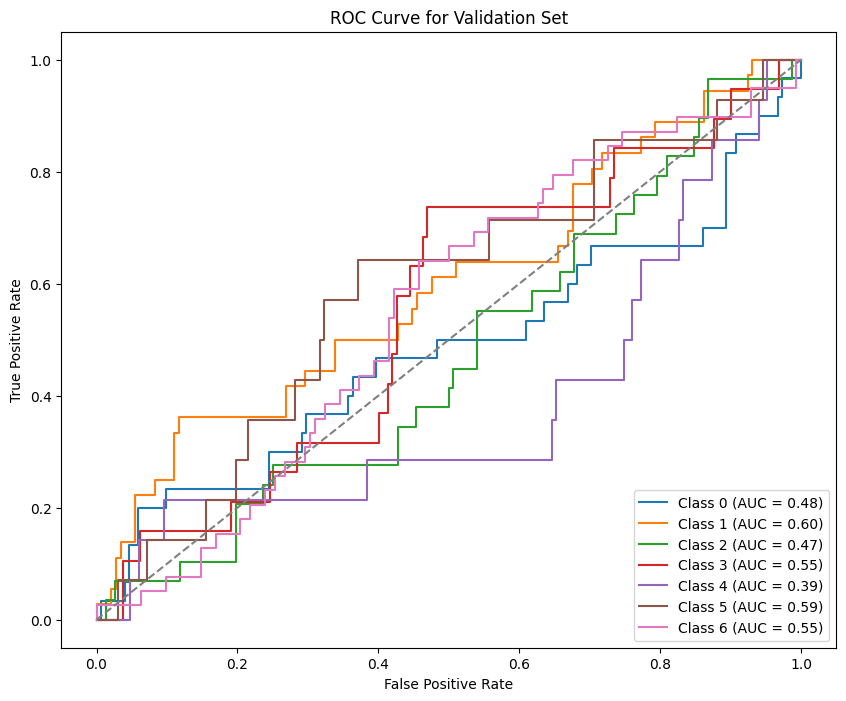

23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 366ms/step


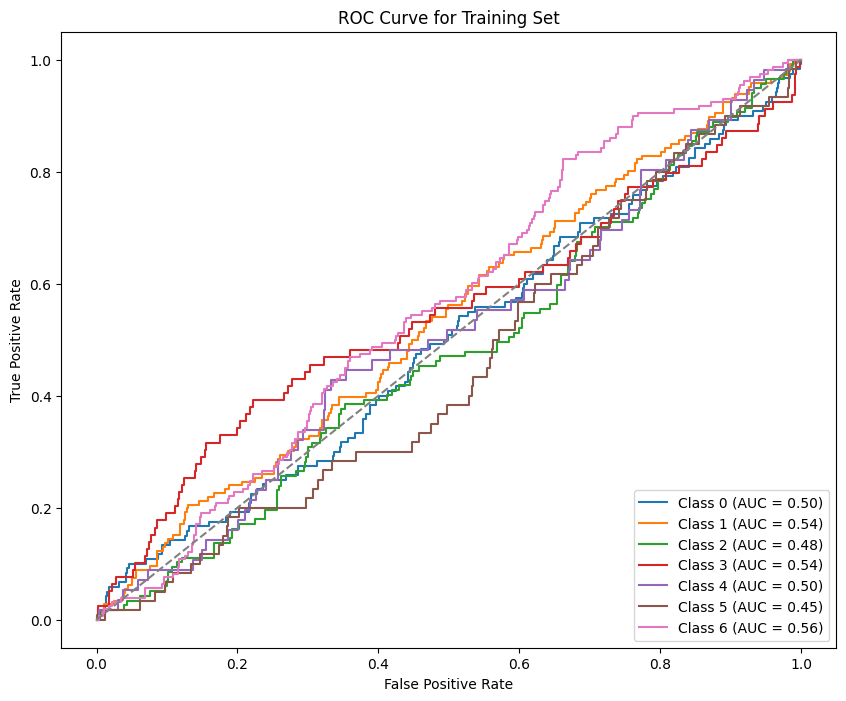

In [95]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Get predictions for validation set
y_pred_val = model.predict(val_generator)
y_true_val = val_generator.classes

# Binarize the true labels for multi-class ROC curve (One-hot encoding)
y_true_val_bin = label_binarize(y_true_val, classes=list(range(num_classes)))

# Compute ROC curve and AUC for each class
fpr, tpr, thresholds = {}, {}, {}
roc_auc = {}

for i in range(num_classes):
    fpr[i], tpr[i], thresholds[i] = roc_curve(y_true_val_bin[:, i], y_pred_val[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for validation set
plt.figure(figsize=(10, 8))

for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

# Plot the diagonal line (no discrimination) as a reference
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

plt.title('ROC Curve for Validation Set')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

# Now repeat the process for the training set
y_pred_train = model.predict(train_generator)
y_true_train = train_generator.classes

# Binarize the true labels for training set
y_true_train_bin = label_binarize(y_true_train, classes=list(range(num_classes)))

# Compute ROC curve and AUC for each class
fpr_train, tpr_train, thresholds_train = {}, {}, {}
roc_auc_train = {}

for i in range(num_classes):
    fpr_train[i], tpr_train[i], thresholds_train[i] = roc_curve(y_true_train_bin[:, i], y_pred_train[:, i])
    roc_auc_train[i] = auc(fpr_train[i], tpr_train[i])

# Plot ROC curve for training set
plt.figure(figsize=(10, 8))

for i in range(num_classes):
    plt.plot(fpr_train[i], tpr_train[i], label=f'Class {i} (AUC = {roc_auc_train[i]:.2f})')

# Plot the diagonal line (no discrimination) as a reference
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

plt.title('ROC Curve for Training Set')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()


In [37]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Optimizer
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Dropout, GlobalAveragePooling2D, Activation, Concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the custom Gazelle Optimizer
class GazelleOptimizer(Optimizer):
    def __init__(self, learning_rate=0.001, beta=0.9, name="GazelleOptimizer", **kwargs):
        super().__init__(learning_rate=learning_rate, name=name, **kwargs)
        self.learning_rate = learning_rate
        self.beta = beta
    
    def apply_gradients(self, grads_and_vars, name=None, experimental_aggregate_gradients=True):
        for grad, var in grads_and_vars:
            new_grad = grad * self.learning_rate  # Modify this logic if needed
            var.assign_sub(new_grad)

    def get_config(self):
        config = {'learning_rate': self.learning_rate, 'beta': self.beta}
        base_config = super(GazelleOptimizer, self).get_config()
        return {**base_config, **config}

# Define the Fire module for the SqueezeNet model
def fire_module(x, squeeze_filters, expand_filters):
    squeeze = Conv2D(squeeze_filters, (1, 1), activation='relu', padding='valid')(x)
    squeeze = BatchNormalization()(squeeze)

    expand_1x1 = Conv2D(expand_filters, (1, 1), activation='relu', padding='valid')(squeeze)
    expand_3x3 = Conv2D(expand_filters, (3, 3), activation='relu', padding='same')(squeeze)

    output = Concatenate()([expand_1x1, expand_3x3])
    output = BatchNormalization()(output)

    return output

# Build the Improved SqueezeNet model for binary classification
def build_improved_squeezenet_binary(input_shape=(128, 128, 3)):
    input_layer = Input(shape=input_shape)

    # Initial convolutional layer
    x = Conv2D(96, (3, 3), strides=(2, 2), activation='relu', padding='same')(input_layer)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

    # Fire modules
    x = fire_module(x, squeeze_filters=16, expand_filters=64)
    x = fire_module(x, squeeze_filters=16, expand_filters=64)
    x = fire_module(x, squeeze_filters=32, expand_filters=128)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

    x = fire_module(x, squeeze_filters=32, expand_filters=128)
    x = fire_module(x, squeeze_filters=48, expand_filters=192)
    x = fire_module(x, squeeze_filters=48, expand_filters=192)
    x = fire_module(x, squeeze_filters=64, expand_filters=256)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

    x = fire_module(x, squeeze_filters=64, expand_filters=256)
    x = Dropout(0.5)(x)  # Regularization

    # Output layer for binary classification
    x = Conv2D(1, (1, 1), activation='relu', padding='valid')(x)  # 1 output for binary classification
    x = BatchNormalization()(x)
    x = GlobalAveragePooling2D()(x)
    output_layer = Activation('sigmoid')(x)  # Sigmoid activation for binary classification

    # Create the model
    model = Model(inputs=input_layer, outputs=output_layer)

    # Compile the model with Gazelle optimizer
    gazelle_optimizer = GazelleOptimizer(learning_rate=0.001, beta=0.9)
    model.compile(optimizer=gazelle_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model



In [39]:
# Data generators for loading and augmenting images
data_dir = 'D:/archive/Herlev DataSet Processed/filtered_images'
datagen = ImageDataGenerator(validation_split=0.2, rescale=1./255)

train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',  # Binary classification
    subset='training'
)

val_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',  # Binary classification
    subset='validation'
)



Found 736 images belonging to 8 classes.
Found 181 images belonging to 8 classes.


In [43]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Optimizer
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Dropout, GlobalAveragePooling2D, Activation, Concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the custom Gazelle Optimizer
class GazelleOptimizer(Optimizer):
    def __init__(self, learning_rate=0.001, beta=0.9, name="GazelleOptimizer", **kwargs):
        super().__init__(learning_rate=learning_rate, name=name, **kwargs)
        self.learning_rate = learning_rate
        self.beta = beta
    
    def apply_gradients(self, grads_and_vars, name=None, experimental_aggregate_gradients=True):
        for grad, var in grads_and_vars:
            new_grad = grad * self.learning_rate  # Modify this logic if needed
            var.assign_sub(new_grad)

    def get_config(self):
        config = {'learning_rate': self.learning_rate, 'beta': self.beta}
        base_config = super(GazelleOptimizer, self).get_config()
        return {**base_config, **config}

# Define the Fire module for the SqueezeNet model
def fire_module(x, squeeze_filters, expand_filters):
    squeeze = Conv2D(squeeze_filters, (1, 1), activation='relu', padding='valid')(x)
    squeeze = BatchNormalization()(squeeze)

    expand_1x1 = Conv2D(expand_filters, (1, 1), activation='relu', padding='valid')(squeeze)
    expand_3x3 = Conv2D(expand_filters, (3, 3), activation='relu', padding='same')(squeeze)

    output = Concatenate()([expand_1x1, expand_3x3])
    output = BatchNormalization()(output)

    return output

# Build the Improved SqueezeNet model for categorical classification (7 classes)
def build_improved_squeezenet_categorical(input_shape=(128, 128, 3), num_classes=7):
    input_layer = Input(shape=input_shape)

    # Initial convolutional layer
    x = Conv2D(96, (3, 3), strides=(2, 2), activation='relu', padding='same')(input_layer)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

    # Fire modules
    x = fire_module(x, squeeze_filters=16, expand_filters=64)
    x = fire_module(x, squeeze_filters=16, expand_filters=64)
    x = fire_module(x, squeeze_filters=32, expand_filters=128)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

    x = fire_module(x, squeeze_filters=32, expand_filters=128)
    x = fire_module(x, squeeze_filters=48, expand_filters=192)
    x = fire_module(x, squeeze_filters=48, expand_filters=192)
    x = fire_module(x, squeeze_filters=64, expand_filters=256)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

    x = fire_module(x, squeeze_filters=64, expand_filters=256)
    x = Dropout(0.5)(x)  # Regularization

    # Output layer for categorical classification (7 classes)
    x = Conv2D(num_classes, (1, 1), activation='relu', padding='valid')(x)  # 7 outputs for categorical classification
    x = BatchNormalization()(x)
    x = GlobalAveragePooling2D()(x)
    output_layer = Activation('softmax')(x)  # Softmax activation for categorical classification

    # Create the model
    model = Model(inputs=input_layer, outputs=output_layer)

    # Compile the model with Gazelle optimizer
    gazelle_optimizer = GazelleOptimizer(learning_rate=0.001, beta=0.9)
    model.compile(optimizer=gazelle_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model


In [47]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set up directories and data generators
data_dir = 'D:/archive/Herlev DataSet Processed/filtered_images'  # Update this with the path to your dataset

# Set up ImageDataGenerator for training and validation
datagen = ImageDataGenerator(
    validation_split=0.2,  # 20% of data for validation
    rescale=1./255,  # Normalize pixel values between 0 and 1
)

# Load the training data
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(128, 128),  # Resize images to 128x128
    batch_size=32,
    class_mode='categorical',  # Multi-class classification
    subset='training',  # Use 80% of the data for training
)

# Load the validation data
val_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',  # Multi-class classification
    subset='validation',  # Use 20% of the data for validation
)


Found 736 images belonging to 7 classes.
Found 181 images belonging to 7 classes.


In [49]:
# Build the model
model = build_improved_squeezenet_categorical(input_shape=(128, 128, 3), num_classes=7)

# Train the model
history = model.fit(
    train_generator,
    epochs=10,  # Set the number of epochs
    validation_data=val_generator,  # Use validation data for evaluation during training
    verbose=1  # Show training progress
)

# Evaluate the model on the validation data
val_loss, val_accuracy = model.evaluate(val_generator, verbose=1)

# Print the evaluation results
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')


Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.1669 - loss: 1.9470 - val_accuracy: 0.1050 - val_loss: 1.9509
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.1651 - loss: 1.9399 - val_accuracy: 0.1050 - val_loss: 1.9615
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.1992 - loss: 1.9225 - val_accuracy: 0.1050 - val_loss: 1.9757
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.2387 - loss: 1.9022 - val_accuracy: 0.1989 - val_loss: 1.9944
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.3240 - loss: 1.8383 - val_accuracy: 0.1989 - val_loss: 2.0143
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.2607 - loss: 1.8591 - val_accuracy: 0.1989 - val_loss: 2.0265
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.3287 - loss: 1.8432 - val_accuracy: 0.1989 - val_loss: 2.0089
Epoch 8/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.3642 - loss: 1.7971 - val_accuracy: 0.1989 - val_loss: